In [56]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Goal to compare accuracy of different test classifications of normal/abnormal MJD against visual classification (not rigorous)
## n = normal, ab = abnormal
## Known that normal mode (82.45%), abnormal mode (17.55%)
5.1 in
https://www2.physik.uni-bielefeld.de/fileadmin/user_upload/radio_astronomy/Publications/Bachelorthesis_MaxKreie.pdf

# 1. Proportions

In [3]:
mjd = np.loadtxt('./data/J0332_MJD.txt')
n_visual= np.loadtxt('./classified_mjd/J0332_norm_mjd_visual.txt')
ab_visual= np.loadtxt('./classified_mjd/J0332_abnorm_mjd_visual.txt')

n_ks = np.loadtxt('./classified_mjd/J0332_norm_mjd_ks.txt')
ab_ks = np.loadtxt('./classified_mjd/J0332_abnorm_mjd_ks.txt')

n_wavelet_diff = np.loadtxt('./classified_mjd/J0332_norm_mjd_wavelet_diff.txt')
ab_wavelet_diff = np.loadtxt('./classified_mjd/J0332_abnorm_mjd_wavelet_diff.txt')

n_wavelet_ratio = np.loadtxt('./classified_mjd/J0332_norm_mjd_wavelet_ratio.txt')
ab_wavelet_ratio = np.loadtxt('./classified_mjd/J0332_abnorm_mjd_wavelet_ratio.txt')

In [4]:
ab_visual, ab_ks

(array([58302., 58337., 58342., 58349., 58363., 58411., 58413., 58425.,
        58434., 58446., 58629., 58632.]), array([58251., 58425., 58481.]))

In [6]:
#Proportions
nprofs = len(n_visual) + len(ab_visual)
print('Visual classification proportions: {:>6}% and {}%'.format(100*round(len(n_visual)/nprofs, 4), \
                                                          100*round(len(ab_visual)/nprofs, 4)))
print('KS test classification proportions: {:>}% and {:>}%'.format(100*round(len(n_ks)/nprofs, 4), \
                                                          100*round(len(ab_ks)/nprofs, 4)))
print('Wavelet difference proportions: {:>}% and {:>}%'.format(100*round(len(n_wavelet_diff)/nprofs, 4), \
                                                          100*round(len(ab_wavelet_diff)/nprofs, 3)))
print('Wavelet ratio proportions: {:>}% and {:>}%'.format(100*round(len(n_wavelet_ratio)/nprofs, 4), \
                                                          100*round(len(ab_wavelet_ratio)/nprofs, 3)))

print('Note that for KS test, using 95th percentile is closer to literature over 99th')
print('Also, because we only have 62 samples, and the sampling was not continuous in time,'
      '\nit is expected that proportions wont be super accurate')

Visual classification proportions:  80.65% and 19.35%
KS test classification proportions: 95.16% and 4.84%
Wavelet difference proportions: 54.84% and 45.2%
Wavelet ratio proportions: 82.26% and 17.7%
Note that for KS test, using 95th percentile is closer to literature over 99th
Also, because we only have 62 samples, and the sampling was not continuous in time,
it is expected that proportions wont be super accurate


### Need better way of dealing with repeating MJDs below, maybe use indices for building DF?
629, 630, 648 are repeating. By the way I am building DF, repeating index will both have normal mode classific
Need to consider repeating MJD for all, inluding visual

# 2. Specific MJDs

In [40]:
df = pd.DataFrame(mjd, columns=['mjd'])
#0 if normal, 1 if abnormal, corresponding to MJD in date column
df['visual'] = pd.DataFrame([0 if date in n_visual else 1 for date in mjd]) 
df['ks'] = pd.DataFrame([0 if date in n_ks else 1 for date in mjd])
df['ks_offset'] = df['ks']+.05
df['wavelet_diff'] = pd.DataFrame([0 if date in n_wavelet_diff else 1 for date in mjd])
df['wavelet_ratio'] = pd.DataFrame([0 if date in n_wavelet_ratio else 1 for date in mjd])

#Adjust for repeating values
df.at[52, ['visual', 'wavelet_diff']] = 1 #2nd MJD for 58629
df.at[53, ['wavelet_ratio']] = 1 #1st MJD for 58630

df['wavelet_diff_offset'] = df['wavelet_diff']+.1
df['wavelet_ratio_offset'] = df['wavelet_ratio']+.15
#create new column to see if classifications of MJD match against visual
#does LHS * 1, where LHS is boolean, but True*1=1
df['match_visual_ks'] = (df['visual'] == df['ks']).mul(1)
df['match_visual_wavelet_diff'] = (df['visual'] == df['wavelet_diff']).mul(1)
df['match_visual_wavelet_ratio'] = (df['visual'] == df['wavelet_ratio']).mul(1)

df.iloc[50:56]

,mjd,visual,ks,ks_offset,wavelet_diff,wavelet_ratio,wavelet_diff_offset,wavelet_ratio_offset,match_visual_ks,match_visual_wavelet_diff,match_visual_wavelet_ratio
50,58625.0,0,0,0.05,0,0,0.1,0.15,1,1,1
51,58629.0,0,0,0.05,0,0,0.1,0.15,1,1,1
52,58629.0,1,0,0.05,1,0,1.1,0.15,0,1,0
53,58630.0,0,0,0.05,0,1,0.1,1.15,1,1,0
54,58630.0,0,0,0.05,0,0,0.1,0.15,1,1,1
55,58631.0,0,0,0.05,0,0,0.1,0.15,1,1,1


In [81]:
def matches(df, plot_values, matches, colors=['k', 'olivedrab','r'], display_mjd=[True, 1]):
    '''Helper function for plotting vertical lines connecting MJDs
    on scatterplot where test result matches visual classification.
    
    Parameters
    ----------
    df : DataFrame
    Columns and its contents are specific to the DataFrame
    defined in this notebook.
    
    plot_values : list
    List containing string of column names which contain
    actual values to be plotted for each test. For example, for
    KS test it would be column ks_offset.
    
    matches : list
    List containing strings of column names. Each column
    contains binary value, identifying matches between the
    test's classification and visual classification. For example,
    for KS test, the column is match_visual_ks
    
    colors : list
    List containing strings of colors to be used in matplotlib.
    
    display_mjd : list
    List containing 2 elements, a boolean deciding whether to 
    display mjd or not, and if True, which test's index from
    plot_values to display.
    '''
    
    for j in range(len(plot_values)):
        text_up = .03
        text_down = .05
        alternator = 1
        
        for i in df.index:
            #if visual classific matches test classific, draw line
            if (df[matches[j]][i] == 1):
                x = df.mjd[i]
                y_lower = df.visual[i]
                y_higher = df[plot_values[j]][i]
                plt.vlines(x=x, ymin=y_lower, ymax=y_higher, color=colors[j], alpha=1)
                #if we want to display MJD
                if display_mjd[0]:
                    #if this is the test for which we want to display MJD
                    if display_mjd[1] == j:
                        #if it's an abnormal classification,
                        if df.visual[i] == 1:
                            if (alternator == 1):
                                plt.text(x-11, y_higher+(text_up), s=int(x), color=colors[j], fontsize=10)
                                alternator *= -1
                            else:
                                plt.text(x-11, y_lower-(text_down), s=int(x), color=colors[j], fontsize=10)
                                alternator *= -1

In [85]:
#Custom Legend cus seaborn is being annoying
#color = color for line intersecting marker
#markerfacecolor = color for marker itself
visual_0 = Line2D([], [], color='w', markerfacecolor='#F95E5E', marker='o', label="Visual Normal", markersize=10)
visual_1 = Line2D([], [], color='w', markerfacecolor='#608DF5', marker='o', label="Visual Abnormal", markersize=10)

ks_0 = Line2D([], [], color='w', markerfacecolor='#09C009', marker='X', label="KS Normal", markersize=10)
ks_1 = Line2D([], [], color='w', markerfacecolor='#700BE2', marker='X', label="KS Abnormal", markersize=10)

dwavelet_0 = Line2D([], [], color='w', markerfacecolor='#EE96EB', marker='^', label="Wavelet Diff Normal", markersize=10)
dwavelet_1 = Line2D([], [], color='w', markerfacecolor='#00EFFF', marker='^', label="Wavelet Diff Abnormal", markersize=10)

rwavelet_0 = Line2D([], [], color='w', markerfacecolor='#000000', marker='s', label="Wavelet Ratio Normal", markersize=10)
rwavelet_1 = Line2D([], [], color='w', markerfacecolor='#FFA200', marker='s', label="Wavelet Ratio Abnormal", markersize=10)

#Match lines
match_ks = Line2D([], [], color='k', label="Visual Match KS")
match_dwavelet = Line2D([], [], color='olive', label="Visual Match Wavelet Diff")
match_rwavelet = Line2D([], [], color='r', label="Visual Match Wavelet Ratio")

handles = [visual_0, visual_1, ks_0, ks_1, dwavelet_0, dwavelet_1, rwavelet_0, rwavelet_1,
           match_ks, match_dwavelet, match_rwavelet]

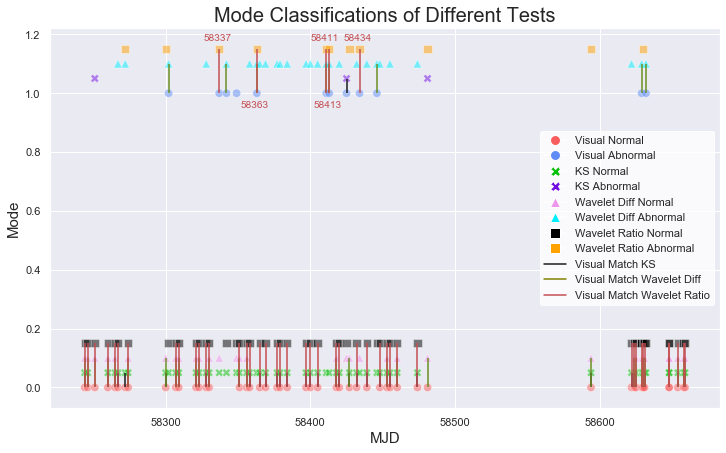

In [86]:
sns.set()
fig = plt.figure(figsize=(12,7))

#plotting keywords for each test
cmaps = [sns.color_palette(['#F95E5E', '#608DF5']), sns.color_palette(['#09C009', '#700BE2']), 
         sns.color_palette(['#EE96EB', '#00EFFF']), sns.color_palette(['#000000', '#FFA200'])]
params = {'y':['visual', 'ks_offset', 'wavelet_diff_offset', 'wavelet_ratio_offset'],
          'hue':['visual', 'ks', 'wavelet_diff', 'wavelet_ratio'],
          'marker':['o', 'X', '^', 's'],
          'alpha':[.5]*4}

for i in range(4):
    ax = sns.scatterplot(x='mjd', y=params['y'][i], data=df, hue=params['hue'][i], palette=cmaps[i],
                         marker=params['marker'][i], s=70, alpha=params['alpha'][i])
    
#Display vlines for matching MJD, and display MJD value for abnormals
matches(df, plot_values=['ks_offset', 'wavelet_diff_offset', 'wavelet_ratio_offset'], 
            matches=['match_visual_ks', 'match_visual_wavelet_diff', 'match_visual_wavelet_ratio'],
            display_mjd=[True,2])
            
ax.set_title('Mode Classifications of Different Tests', fontdict={'fontsize':20})
ax.set_xlabel('MJD', size=15)
ax.set_ylabel('Mode', size=15)

legend = plt.legend(handles=handles, loc='center right')
frame = legend.get_frame()
frame.set_color('white')

plt.savefig('./plots/test_comp.jpeg')

In [84]:
len(ab_visual), len(ab_wavelet_diff), len(ab_ks), len(ab_wavelet_ratio)

(12, 28, 3, 11)

In [87]:
ab_ks

array([58251., 58425., 58481.])